# Red Neuronal Recurrente LSTM 

In [565]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
# import tensorflowjs as tfjs
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError 
import json

### Este modelo de IA realizará el análisis técnico sobre la criptmoneda Bitcoin (BTC)

#### Importación de bibliotecas

In [566]:
def categorize(change):
    if change >= 0.00:
        return 1
    else:
        return 0

#### Dataset

In [567]:
bp = pd.read_csv("./BitcoinHistoricalData.csv",index_col='Date',parse_dates=['Date']).iloc[::-1]

In [568]:
columns = ["Price","Open","High","Low","Vol.","Change %"]

for col in columns:
    bp[col] = pd.to_numeric(bp[col].replace({',': '', 'K': 'e3', 'M': 'e6', 'B': 'e9','%':''}, regex=True), errors='coerce')

In [569]:
bp['Category'] = [categorize(i) for i in bp['Change %']]

Se verifica que los tipos de datos sean los correctos

In [570]:
bp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3633 entries, 2015-01-01 to 2024-12-11
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3633 non-null   float64
 1   Open      3633 non-null   float64
 2   High      3633 non-null   float64
 3   Low       3633 non-null   float64
 4   Vol.      3633 non-null   float64
 5   Change %  3633 non-null   float64
 6   Category  3633 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 227.1 KB


In [571]:
bp.describe()

,Price,Open,High,Low,Vol.,Change %,Category
count,3633.000000,3633.000000,3633.000000,3633.000000,3.633000e+03,3633.000000,3633.000000
mean,19700.455133,19673.790779,20136.513267,19189.664134,1.700008e+07,0.225923,0.529039
std,21479.182685,21442.766496,21923.994289,20955.292279,1.814801e+08,3.676156,0.499225
min,164.900000,164.900000,212.600000,157.300000,2.600000e+02,-39.180000,0.000000
25%,2559.200000,2558.400000,2617.800000,2478.200000,5.704000e+04,-1.230000,0.000000
50%,9609.400000,9602.200000,9799.500000,9368.400000,1.055700e+05,0.140000,1.000000
75%,31308.700000,31152.000000,32185.600000,30227.900000,3.100400e+05,1.720000,1.000000
max,101115.800000,101129.700000,103719.400000,98969.000000,4.470000e+09,27.200000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

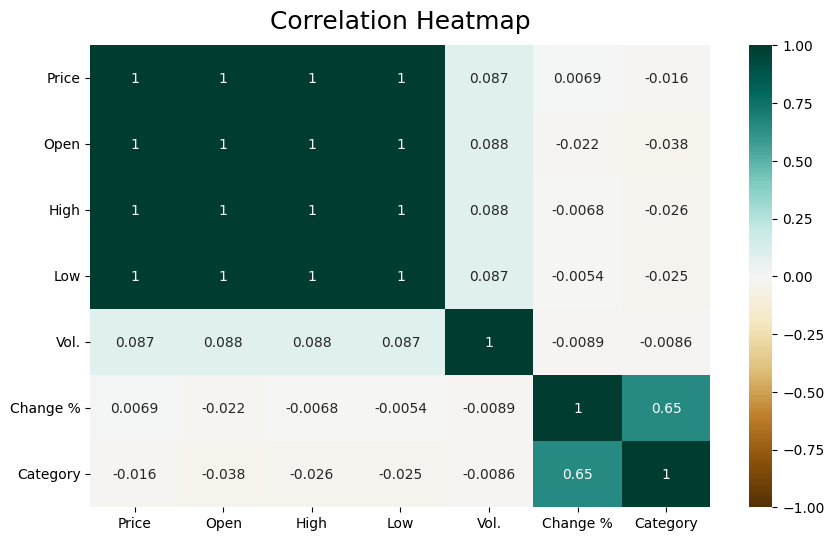

In [572]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(bp.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Verificación de valores nulos

In [573]:
bp.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Category    0
dtype: int64

Dataset de Entrenamiento (2011 - 2019)

In [574]:
train_set = bp[:"2019"].iloc[:,[0]]
# train_set_target = to_categorical(bp[:'2019'].iloc[:,[6]], num_classes=3)

Dataset de Prueba (2022 - 2024)

In [575]:
test_set = bp['2022':].iloc[:,[0]]
test_set
# validation_set_target = to_categorical(bp['2022':'2023'].iloc[:,[6]], num_classes=3)

,Price
Date,
2022-01-01,47738.0
2022-01-02,47311.8
2022-01-03,46430.2
2022-01-04,45837.3
2022-01-05,43425.9
...,...
2024-12-07,99837.0
2024-12-08,101115.8
2024-12-09,97359.4


Visualizacion de Datasets

Text(0, 0.5, 'Precio')

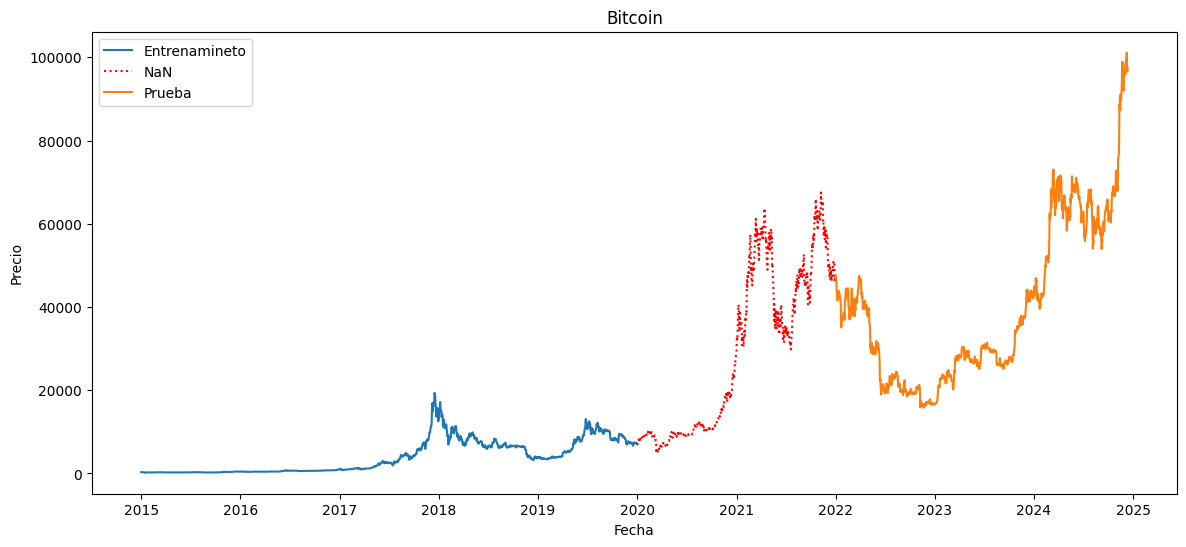

In [576]:
plt.figure(figsize=(14,6))
plt.title("Bitcoin")
sns.lineplot(x="Date", y="Price", data=train_set, label="Entrenamineto")
sns.lineplot(x="Date", y="Price", data=bp['2020':'2021'].iloc[:,[0]], label="NaN",linestyle='dotted', color='red')
sns.lineplot(x="Date", y="Price", data=test_set, label="Prueba")
plt.xlabel("Fecha")
plt.ylabel("Precio")

### Normalización de los datos

In [577]:
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)    
test_set.describe()

,Price
count,1076.000000
mean,39956.120539
std,19374.955129
min,15776.200000
25%,24381.000000
50%,34315.800000
75%,57781.300000
max,101115.800000


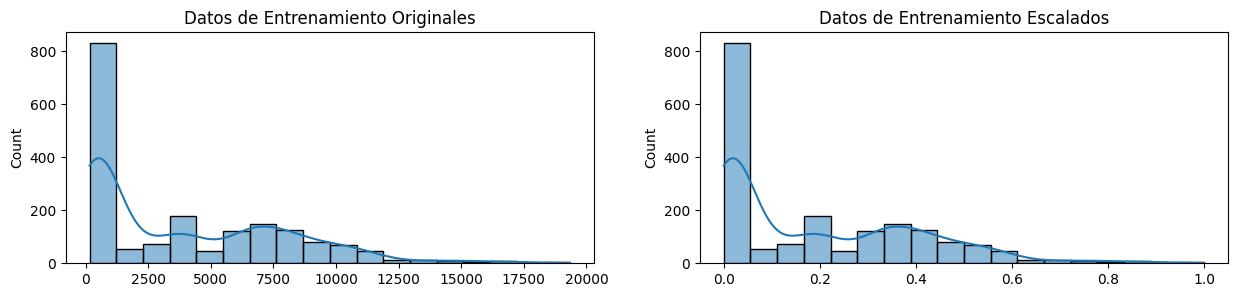

In [578]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(train_set, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos de Entrenamiento Originales")
sns.histplot(train_set_scaled, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos de Entrenamiento Escalados")
plt.show()

### Ajuste de los sets de entrenamineto y validación

In [579]:
block_size = 7
X_train = []
Y_train = []    
m = len(train_set_scaled)

for i in range(block_size,m):
    # Para X_train toma los primeros 'block_size' valores del dataset y Y_train toma el siguiente valor 
    X_train.append(train_set_scaled[i-block_size:i,0])
    Y_train.append(train_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train) 

In [580]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape

### Creación y entrenamiento de la Red LSTM

In [581]:
input_dim = (X_train.shape[1],X_train.shape[2])
output_dim = 1
na = 60

In [582]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Model Construction
model = Sequential()

# First Bidirectional LSTM Layer with Dropout and BatchNormalization
model.add(Bidirectional(LSTM(units=na, return_sequences=True), input_shape=input_dim))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second Bidirectional LSTM Layer with fewer units
model.add(Bidirectional(LSTM(units=na // 2, return_sequences=True)))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

# Third LSTM layer without bidirectionality, focusing on sequential data
model.add(LSTM(units=na // 4, return_sequences=False))
# model.add(Dropout(0.3))

# Dense layers to refine the output
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=output_dim, activation='linear'))  # Output layer for continuous prediction

# Compiling the model with advanced metrics
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Model Training
hist = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Model Summary
model.summary()



C:\Users\GMS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0116 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 1356.3472 - mean_squared_error: 0.0116 - root_mean_squared_error: 0.1057 - val_loss: 0.1089 - val_mean_absolute_error: 0.3041 - val_mean_absolute_percentage_error: 78.5760 - val_mean_squared_error: 0.1089 - val_root_mean_squared_error: 0.3300 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 4538.6367 - mean_squared_error: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.1006 - val_mean_absolute_error: 0.2917 - val_mean_absolute_percentage_error: 75.2039 - val_mean_squared_error: 0.1006 - val_root_mean_squared_error: 0.3173 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 2384.9434 - mean_squared_error: 0.0026 - root_mean_squared_error: 0.0509 - 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_32                │ (None, 7, 120)         │        29,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 7, 120)         │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 7, 60)          │        36,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 7, 60)          │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 15)             │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,533 (869.27 KB)

 Trainable params: 74,057 (289.29 KB)

 Non-trainable params: 360 (1.41 KB)

 Optimizer params: 148,116 (578.58 KB)

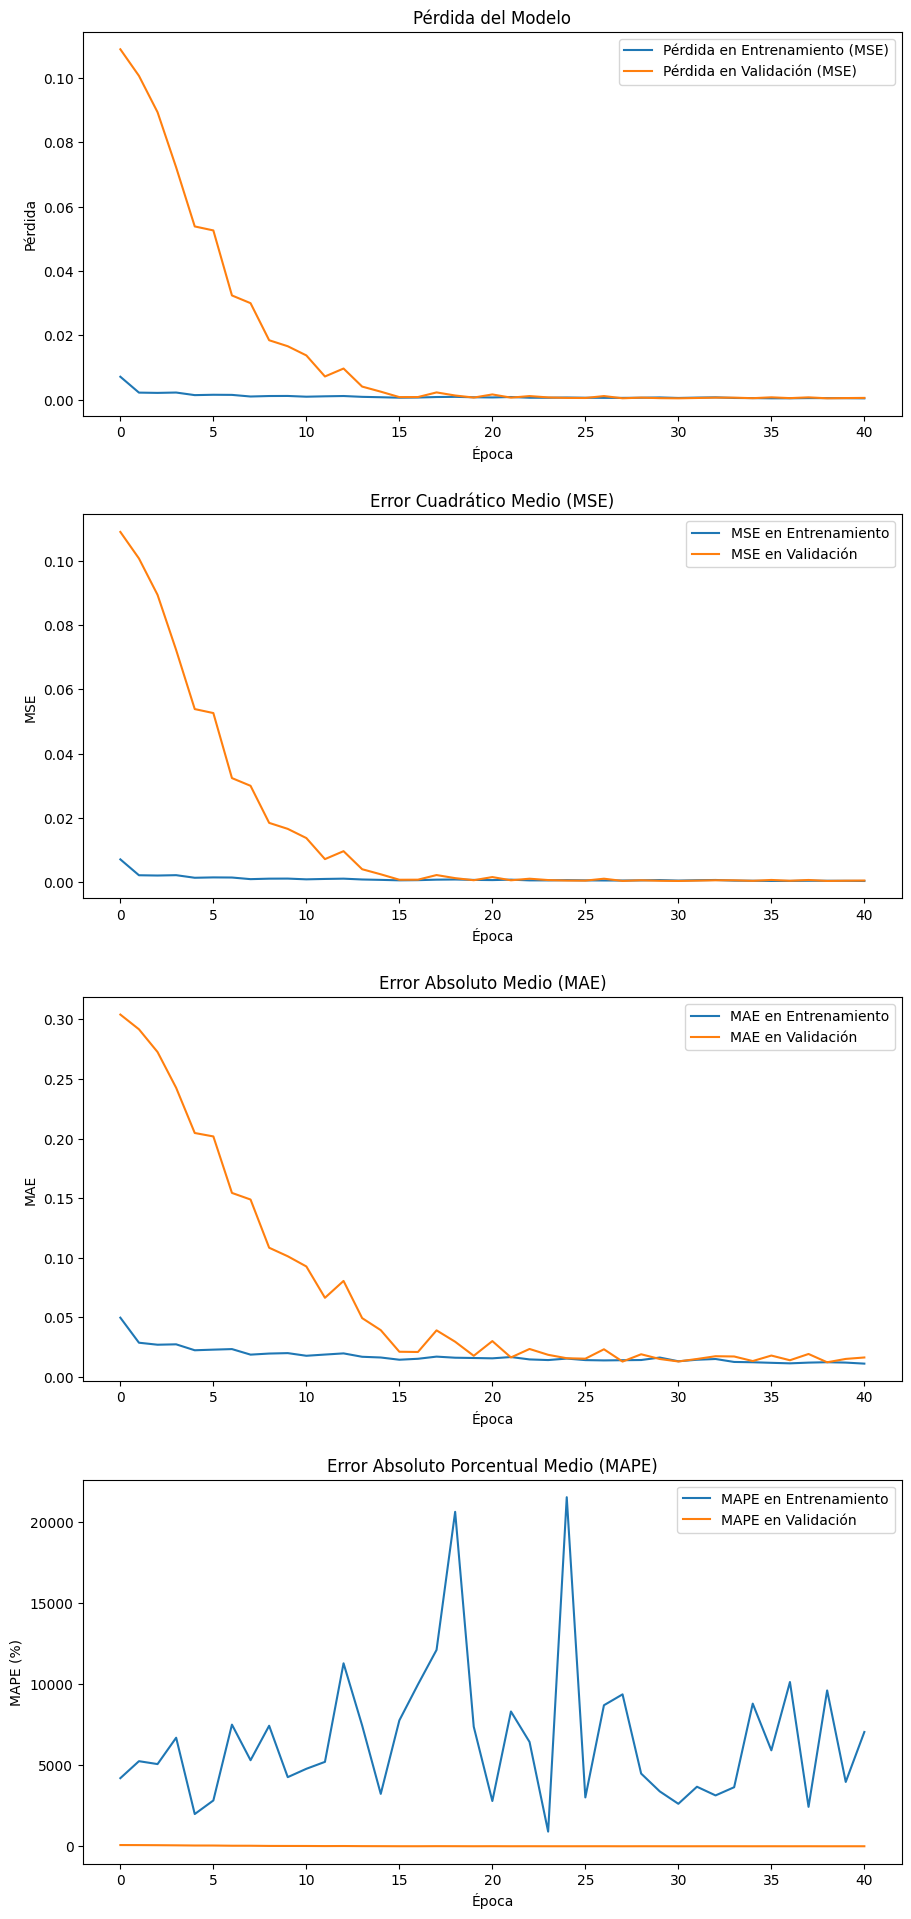

In [583]:
import matplotlib.pyplot as plt

# Crear una figura con 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Gráfico de la pérdida
axes[0].plot(hist.history['loss'], label="Pérdida en Entrenamiento (MSE)")
axes[0].plot(hist.history['val_loss'], label="Pérdida en Validación (MSE)")
axes[0].set_title("Pérdida del Modelo")
axes[0].set_ylabel("Pérdida")
axes[0].set_xlabel("Época")
axes[0].legend()

# Gráfico del MSE
axes[1].plot(hist.history['mean_squared_error'], label="MSE en Entrenamiento")
axes[1].plot(hist.history['val_mean_squared_error'], label="MSE en Validación")
axes[1].set_title("Error Cuadrático Medio (MSE)")
axes[1].set_ylabel("MSE")
axes[1].set_xlabel("Época")
axes[1].legend()

# Gráfico del MAE
axes[2].plot(hist.history['mean_absolute_error'], label="MAE en Entrenamiento")
axes[2].plot(hist.history['val_mean_absolute_error'], label="MAE en Validación")
axes[2].set_title("Error Absoluto Medio (MAE)")
axes[2].set_ylabel("MAE")
axes[2].set_xlabel("Época")
axes[2].legend()

# Gráfico del MAPE
axes[3].plot(hist.history['mean_absolute_percentage_error'], label="MAPE en Entrenamiento")
axes[3].plot(hist.history['val_mean_absolute_percentage_error'], label="MAPE en Validación")
axes[3].set_title("Error Absoluto Porcentual Medio (MAPE)")
axes[3].set_ylabel("MAPE (%)")
axes[3].set_xlabel("Época")
axes[3].legend()

plt.show()



### Prediccion

In [584]:
x_test = sc.fit_transform(test_set)

In [585]:
X_test = []
for i in range(block_size,len(x_test)):
    X_test.append(x_test[i-block_size:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [586]:
prediccion = model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


In [587]:
prediccion = sc.inverse_transform(prediccion)
graph = test_set[block_size:]
graph['Prediction']  = prediccion

C:\Users\GMS\AppData\Local\Temp\ipykernel_18028\3464148111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['Prediction']  = prediccion


In [588]:
def change(pred):
    change = []
    for x in range(0,len(pred)):
        if x < len(pred)-1:
            if pred[x] < pred[x+1]:
                change.append(1)
            else:
                change.append(0)
        else:
            change.append(1)
    return change
graph['Change'] = change(prediccion)

C:\Users\GMS\AppData\Local\Temp\ipykernel_18028\1289621115.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['Change'] = change(prediccion)


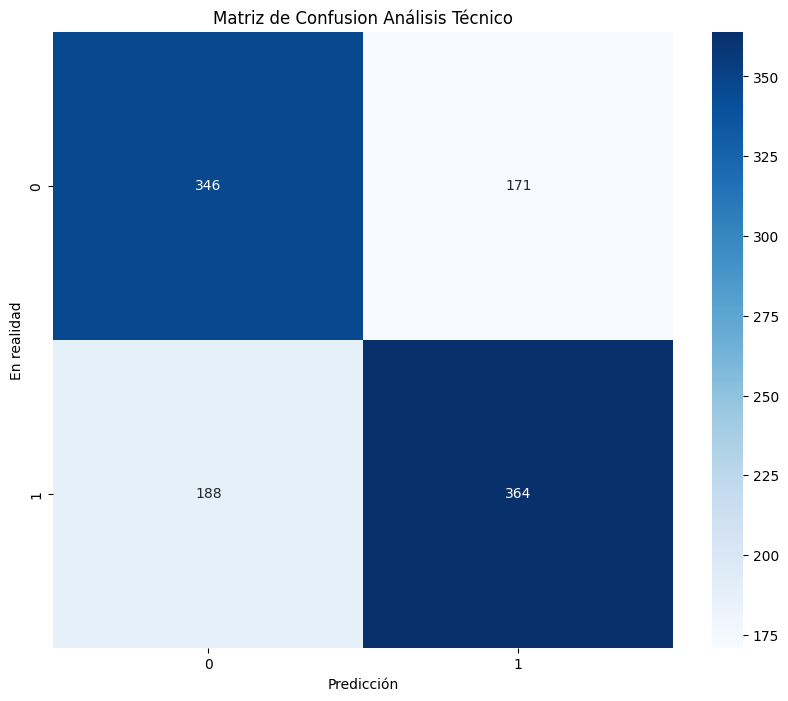

In [589]:

conf_matrix = confusion_matrix(graph["Change"], bp["Category"][graph.index.min():])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicción')
plt.ylabel('En realidad')
plt.title('Matriz de Confusion Análisis Técnico')
plt.show()

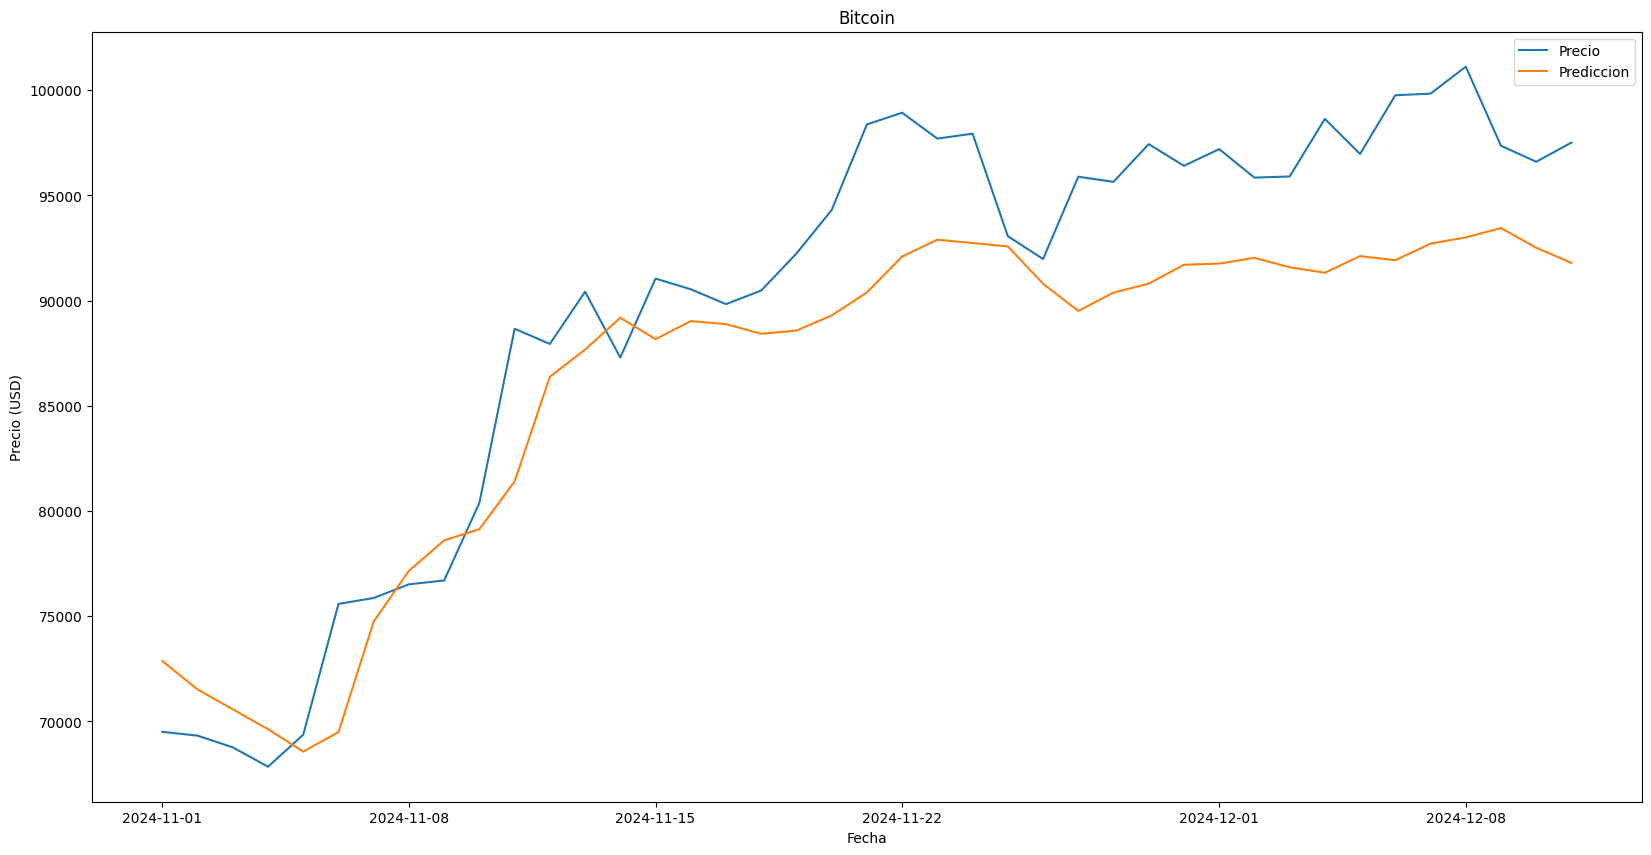

In [596]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='Date', y='Price', data=graph['11/2024':], label='Precio')
sns.lineplot(x='Date', y='Prediction', data=graph['11/2024':], label='Prediccion')
plt.title('Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

In [591]:
# import numpy as np

# # Supongamos que estas son las predicciones de tu modelo
# predicciones = np.array(prediccion.flatten())

# # Calcular diferencias entre valores consecutivos
# diferencias = np.diff(predicciones)

# # Clasificar como subida (1) o bajada (0)
# clasificaciones = np.where(diferencias > 0, 1, 0)

# # Calcular la probabilidad de subida y bajada
# total = len(clasificaciones)
# probabilidad_subida = np.sum(clasificaciones) / total
# probabilidad_bajada = 1 - probabilidad_subida


# # Mostrar resultados
# print(f"Probabilidad de subida: {probabilidad_subida * 100:.2f}%")
# print(f"Probabilidad de bajada: {probabilidad_bajada * 100:.2f}%")


In [592]:
# Guarda el modelo sin especificar `batch_shape`
# model.save('model3.h5', save_format='h5')


# # Convert numpy types to Python native types
# history_dict = {key: [float(value) for value in values] for key, values in hist.history.items()}

# # Save the converted history to a JSON file
# with open('training_history.json', 'w') as f:
#     json.dump(history_dict, f)
